In [ ]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.10.0

# Linear regression exercises

Source: https://github.com/aloctavodia/BAP

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from IPython.display import SVG, display
from pandas.plotting import parallel_coordinates
from scipy import stats
from theano import shared, tensor

np.random.seed(seed=0)
az.style.use('arviz-darkgrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Question 1
***

*Check the following definition of a probabilistic model. Identify the likelihood, the prior and the posterior:*

\begin{eqnarray}
y_i \text{~} Normal(\mu, \sigma) \newline
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} \left|Normal(0,25) \right|
\end{eqnarray}

The priors in this model are:

\begin{eqnarray}
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} \left|Normal(0,25) \right|
\end{eqnarray}


The likelihood in our model is  :
$$ Normal(\mu, \sigma)$$

And the posterior will be a distribution over $\mu$ and $\sigma$, but the posterior is not directly specified in the model (it is the result of Bayes formula!).

## Question 2
***

*For the model in exercise 1, how many parameters will the posterior have? In other words, how many dimensions will it have?*

There are two parameters in this model: $\mu$ and $\sigma$. So the posterior is 2-dimensional.

## Question 3
***

*Check the following model. Identify the linear model and the likelihood. How many parameters does the posterior have?*

\begin{eqnarray}
y \text{~} Normal(\mu, \epsilon) \newline
\mu = \alpha + \beta x \newline
\alpha \text{~} Normal(0,10) \newline
\beta \text{~} Normal(0,1) \newline
\epsilon \text{~} \left|Normal(0,25) \right|
\end{eqnarray}

The linear model is:
\begin{eqnarray}
\mu = \alpha + \beta x
\end{eqnarray}


The likelihood in our model is:  
$$ Normal(\mu, \epsilon)$$

The posterior will have three parameters:

$$ \alpha, \beta, \epsilon $$

## Question 5
***

*For the model in exercise 1, assume that you have a dataset with 57 data points coming from a Gaussian with a mean of 4 and a standard deviation of 0.5. Using PyMC3, compute:*
- The posterior distribution
- The prior distribution
- The posterior predictive distribution
- The prior predictive distribution

*Tip: Besides `pm.sample()`, PyMC3 has other functions to compute samples.*

For this exercise we will generate 57 datapoints from a distribution of $Normal(4, 0.5)$:

In [ ]:
data = stats.norm(4,.5).rvs(size=57)

In [ ]:
with pm.Model() as model:
    mu = pm.Normal("mu", 0, 10)
    sd = pm.HalfNormal("sd", 25)
    y = pm.Normal("y,", mu, sd, observed=data)
    
    # Compute both prior, and prior predictive
    prior_predictive = pm.sample_prior_predictive()
    
    # Compute posterior
    trace = pm.sample()
    
    # Compute posterior predictive
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [6]:
dataset = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive, prior=prior_predictive)
dataset

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

Let's plot the prior distributions to get a sense of what the Bayesian model's estimations without data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b207cc0>,
      dtype=object)

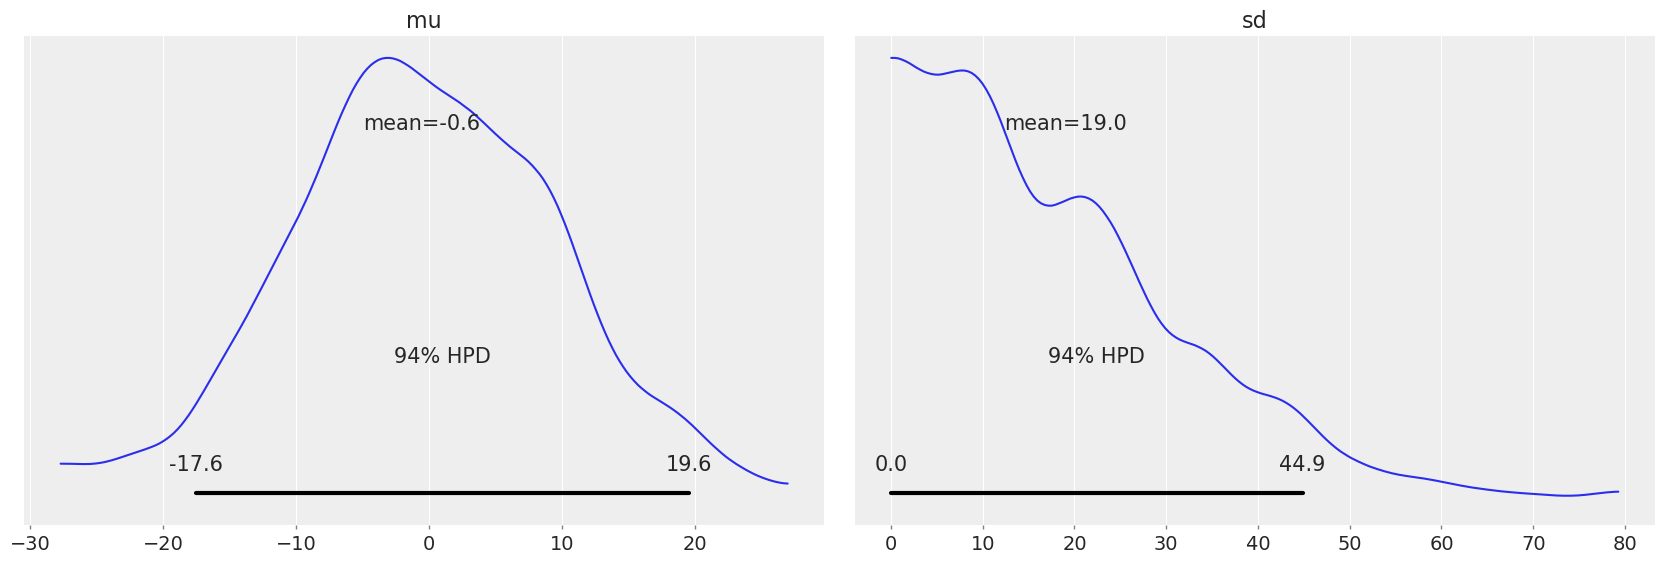

In [7]:
# The plot_posterior method can be used to plot priors as well
az.plot_posterior(dataset.prior, var_names=["mu", "sd"]);

Now let's plot the posterior, to check the distributions after update:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c282e27b8>,
      dtype=object)

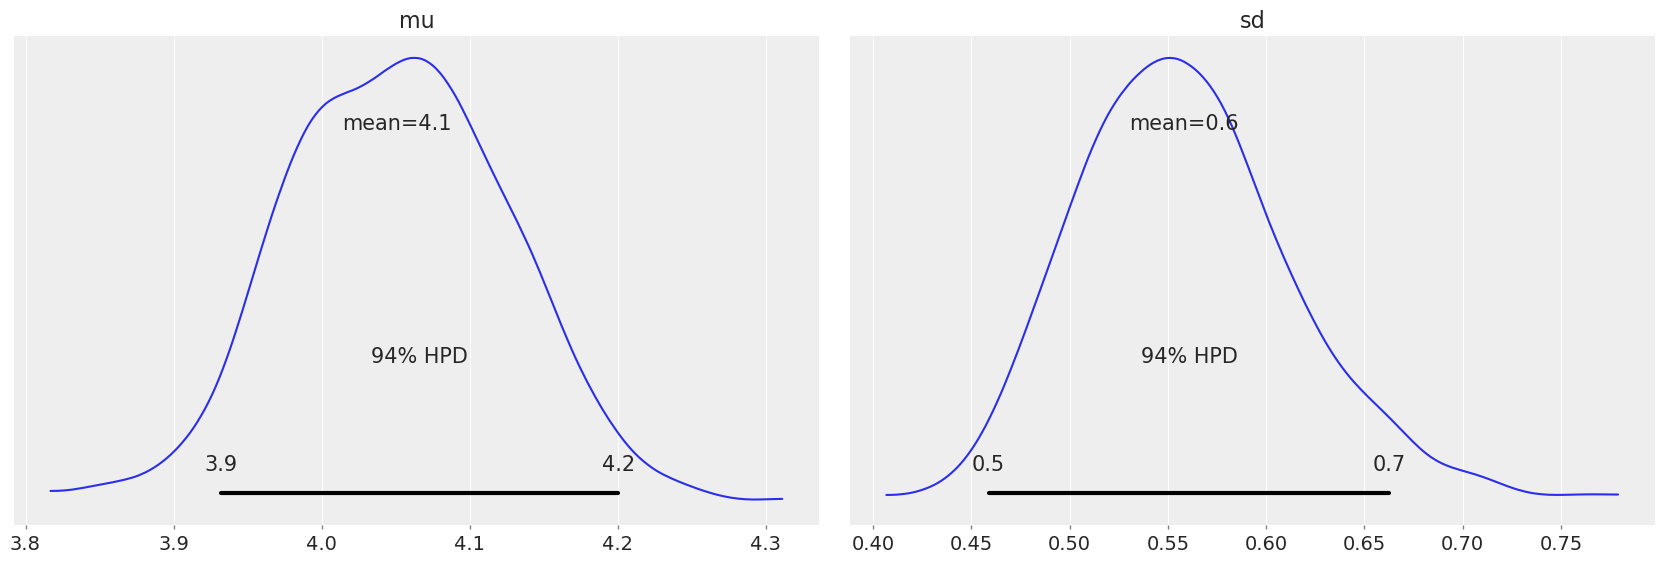

In [8]:
# Compare above plot to posterior distribution below, as well as to original parameters in distribution
az.plot_posterior(dataset)

The exercise also asks for the prior predictive values. We'll need to do some data manipulation to get the data into a format we can use with ArviZ:

In [9]:
dataset.prior

<xarray.Dataset>
Dimensions:   (chain: 1, draw: 500, y,_dim_0: 57)
Coordinates:
  * chain     (chain) int64 0
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * y,_dim_0  (y,_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 48 49 50 51 52 53 54 55 56
Data variables:
    sd        (chain, draw) float64 0.5084 33.7 19.04 ... 79.27 4.737 33.71
    y,        (chain, draw, y,_dim_0) float64 3.632 2.833 1.979 ... -33.26 11.49
    mu        (chain, draw) float64 3.025 -6.343 -3.627 ... -6.78 12.98 -23.64
    sd_log__  (chain, draw) float64 -0.6766 3.517 2.947 ... 4.373 1.556 3.518
Attributes:
    created_at:                 2019-03-16T02:34:03.270827
    inference_library:          pymc3
    inference_library_version:  3.6

Let's also plot the prior predictive values, we'll need to do some data manipulation to get the data into a format we can use with ArviZ

In [10]:
print(dataset.prior["y,"].values.shape)
prior_predictive = dataset.prior["y,"].values.flatten()
prior_predictive.shape

(1, 500, 57)


(28500,)

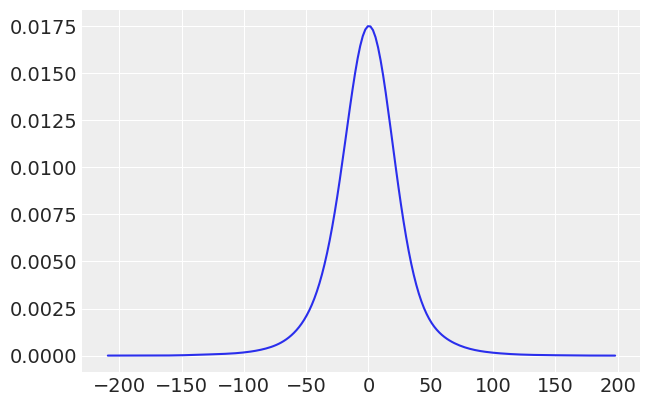

In [11]:
az.plot_kde(prior_predictive);

We can them compare this to the posterior predictive distribution:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28da19b0>],
      dtype=object)

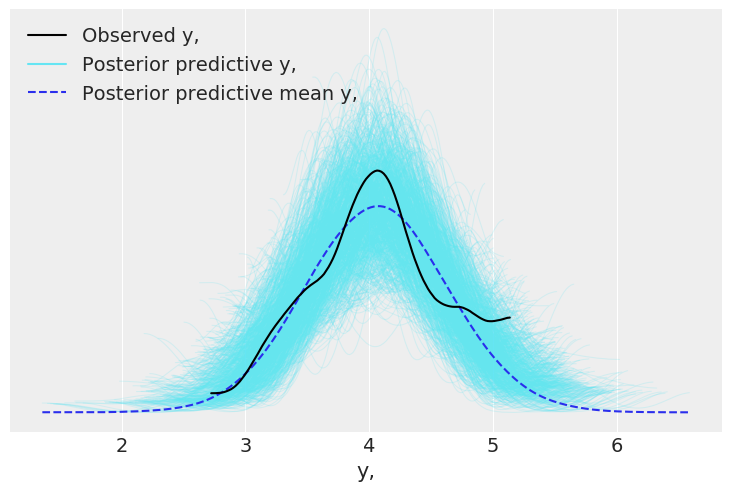

In [12]:
az.plot_ppc(dataset);

## Question 5
***

*Use the howell dataset to create a linear model of the weight ($x$) against the height ($y$). Exclude subjects that are younger than 18. Explain the results.*

Let's import the dataset and create a mask for people older than 18:

In [21]:
howell = pd.read_csv("../code/data/howell.csv", delimiter=";")
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [22]:
age_18_mask = howell["age"] > 18

A good first step is before diving into statistics is to look at the data and ask if it make sense. In my experience taller people tend to weigh more than shorter people. Let's check the data to be sure.

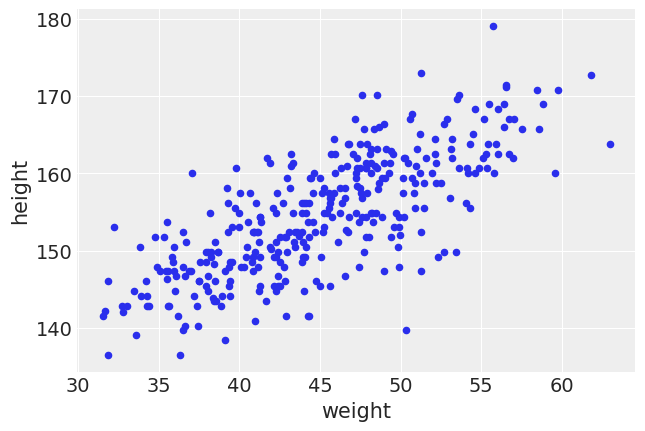

In [23]:
howell[age_18_mask].plot(kind="scatter", x="weight", y="height");

When looking at the plot above this is with consistent our expectations. As weight increases, height increases as well. From visual inspection, it looks like a linear fit with some noise is best. In this case we will assume constant variance. Let's create a model:

In [24]:
height = howell["height"]
weight = howell["weight"]

In [25]:
with pm.Model() as over_18_heights:
    α = pm.Normal("α", sd=10)
    β = pm.Normal("β", sd=10)
    ϵ = pm.HalfNormal("ϵ", sd=10)
    
    weight_shared = shared(weight[age_18_mask].values * 1.)
    μ = pm.Deterministic("μ", α+β*weight_shared)
    
    height_pred = pm.Normal("height_pred", mu=μ, sd=ϵ, observed = height[age_18_mask])
    trace_over_18_heights = pm.sample(tune=2000)
    ppc_over_18_heights = pm.sample_posterior_predictive(trace_over_18_heights, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:14<00:00, 347.37draws/s]
The acceptance probability does not match the target. It is 0.8949160386428021, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:02<00:00, 105.64it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22802f60>,
      dtype=object)

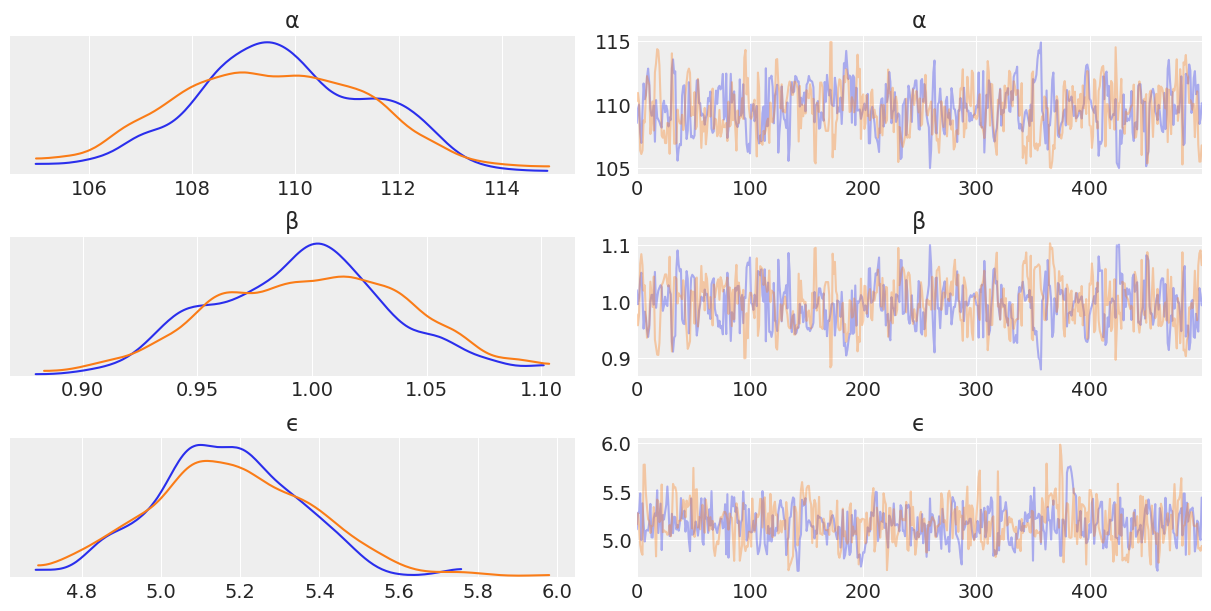

In [26]:
az.plot_trace(trace_over_18_heights, var_names = ["α","β", "ϵ"]);

Looking at the traceplot it looks like the inference engine was able to explore the posterior adequately. Let's plot the regression and the hpd.

Text(0.5, 0.98, 'Weight vs Height fit and posterior predictive checks')

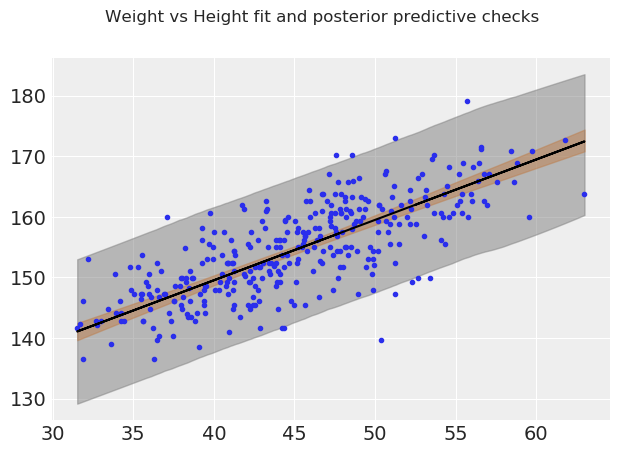

In [27]:
fig, ax = plt.subplots()

ax.plot(weight[age_18_mask], height[age_18_mask], "C0.")
μ_m = trace_over_18_heights["μ"].mean(0)
ϵ_m = trace_over_18_heights["ϵ"].mean()

ax.plot(weight[age_18_mask], μ_m, c="k")
az.plot_hpd(weight[age_18_mask], trace_over_18_heights["μ"], credible_interval=.98)
az.plot_hpd(weight[age_18_mask], ppc_over_18_heights["height_pred"], credible_interval=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

From visual inspection the average parameters of the fit look quite good, and the 98% interval of the posterior predictive checks covers most of the distribution. Overall, it looks like a linear fit is great for height vs weight for people over 18!